# **Initializations and Dataset download**

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: satishnaiduvulli
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 601MB/s] 


# **Import Dependencies**

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import torchvision.transforms as transforms
from torchvision import models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# **Reading Data paths**

In [ ]:
device = "cuda" if torch.cuda.is_available else "CPU"
print(device)

cuda


In [ ]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

data_df = pd.concat([train_df, val_df], ignore_index=True)

print("Data shape is: ", data_df.shape)

Data shape is:  (1167, 2)


In [ ]:
data_df.head(5)

,image:FILE,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0


# **Data Inspection**

In [ ]:
print("Classes are: ")
print(data_df["category"].unique())

Classes are: 
[0 1 2]


In [ ]:
print("Classes distributions are: ")
print(data_df["category"].value_counts())

Classes distributions are: 
category
2    393
1    389
0    385
Name: count, dtype: int64


# **Data Splitting**

In [ ]:
train = data_df.sample(frac=0.7, random_state=7)
test = data_df.drop(train.index)
print(train.shape)
print(test.shape)

(817, 2)
(350, 2)


# **Preprocessing Objects**

In [ ]:
label_encoder = LabelEncoder()

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

# **Custom Dataset Class**

In [ ]:
class CustomImageDataset(Dataset):

  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.fit_transform(dataframe['category'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [ ]:
# Explicitly set the device to CPU
device = "cpu"

print(device)

cpu


# **Create Dataset Object**

In [ ]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

# **Visualize Images**

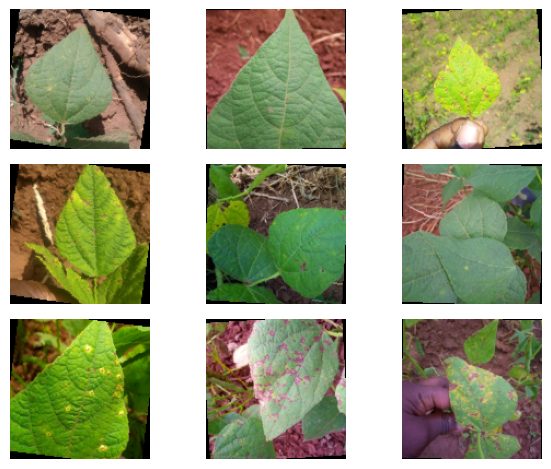

In [ ]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
  for col in range(n_cols):
    image_tensor = train_dataset[np.random.randint(0, train_dataset.__len__())][0].cpu()
    image_np = (image_tensor.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
    axarr[row, col].imshow(image_np)
    axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

# **Hyper Parameters**

In [ ]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
googlenet_model = models.googlenet(weights='DEFAULT')
for param in googlenet_model.parameters():
  param.requires_grad = True

In [ ]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [ ]:
num_classes = len(data_df["category"].unique())
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=LR)

# **Training**

In [ ]:
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for(inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis=1)==labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  print(f'Epoch: {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100,4)} Train Accuracy: {round(total_acc_train/train_dataset.__len__()* 100,4)}%')
  print()

Epoch: 1/15, Train Loss: 1.6363 Train Accuracy: 64.8715%

Epoch: 2/15, Train Loss: 1.4083 Train Accuracy: 72.3378%

Epoch: 3/15, Train Loss: 1.1194 Train Accuracy: 80.1714%

Epoch: 4/15, Train Loss: 1.2081 Train Accuracy: 77.4786%

Epoch: 5/15, Train Loss: 1.0259 Train Accuracy: 81.1506%

Epoch: 6/15, Train Loss: 0.8333 Train Accuracy: 85.8017%

Epoch: 7/15, Train Loss: 0.6933 Train Accuracy: 87.7601%

Epoch: 8/15, Train Loss: 0.6998 Train Accuracy: 89.3513%

Epoch: 9/15, Train Loss: 0.7233 Train Accuracy: 88.6169%

Epoch: 10/15, Train Loss: 0.6002 Train Accuracy: 89.9633%

Epoch: 11/15, Train Loss: 0.5697 Train Accuracy: 91.6769%

Epoch: 12/15, Train Loss: 0.6239 Train Accuracy: 89.9633%

Epoch: 13/15, Train Loss: 0.5304 Train Accuracy: 91.3097%

Epoch: 14/15, Train Loss: 0.4671 Train Accuracy: 92.5337%

Epoch: 15/15, Train Loss: 0.4893 Train Accuracy: 91.6769%



# **Testing**

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  googlenet_model.eval()

  for indx, (input,labels) in enumerate(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis=1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy score is: 91.71%


# **Plot the Loss**

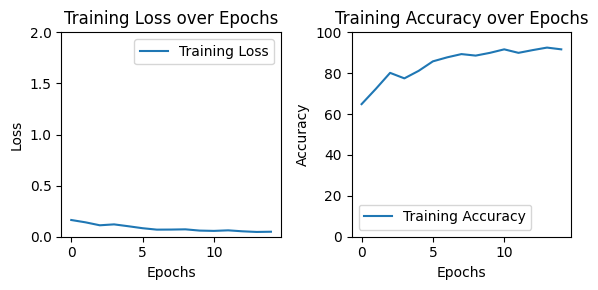

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_ylim([0,100])
axs[1].legend()

plt.tight_layout()
plt.show()